In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy.io 
import matplotlib.pyplot as plt
import numpy as np

mat = scipy.io.loadmat('RAT2_SESS1_extracted_clusters.mat')

spike_ids, spike_times, id_conversions = mat['clusters']['spike_id'][0,0], mat['clusters']['spike_times'][0,0], mat['clusters']['id_conversion'][0,0]

In [10]:
avg_FR = []
for neuron in np.unique(spike_ids):
    spikes = spike_times[spike_ids==neuron]
    avg_FR.append(len(spikes)/(spike_times.max()-spike_times.min()))

isi, cv = [], []
for neuron in np.unique(spike_ids):
    spikes = spike_times[spike_ids==neuron]
    inter_spike_intervals = np.diff(spikes)
    isi.append(inter_spike_intervals)
    cv.append(inter_spike_intervals.std()/inter_spike_intervals.mean())

In [50]:
a = torch.arange(1,10,dtype=torch.float32).unsqueeze(0).unsqueeze(0).repeat(3,3,1)
print(a.shape)

torch.Size([3, 3, 9])


In [52]:
torch.nn.functional.interpolate(a, scale_factor=(.5))

tensor([[[1., 3., 5., 7.],
         [1., 3., 5., 7.],
         [1., 3., 5., 7.]],

        [[1., 3., 5., 7.],
         [1., 3., 5., 7.],
         [1., 3., 5., 7.]],

        [[1., 3., 5., 7.],
         [1., 3., 5., 7.],
         [1., 3., 5., 7.]]])

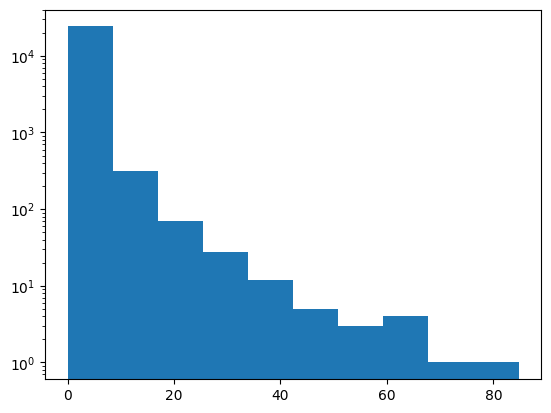

In [11]:
plt.hist(isi[0])
plt.yscale('log')

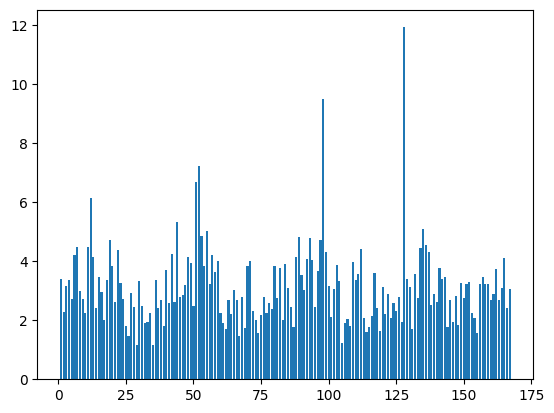

In [12]:
plt.bar(np.unique(spike_ids),cv);

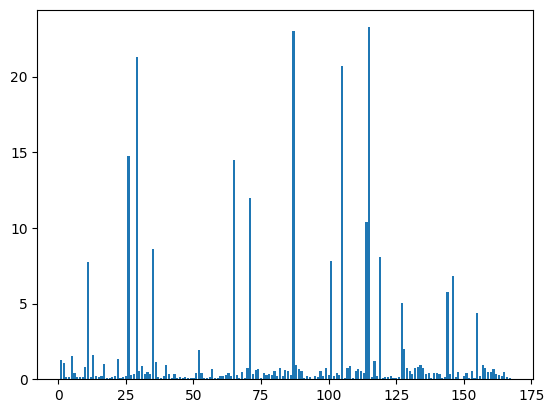

In [13]:
plt.bar(np.unique(spike_ids),avg_FR);

In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from dataset_generation import generate_dataset, sm_generative_model
from wassa_plots import plot_SM, plot_colored_raster

# Generative model for raster plots and spiking motifs

List of parameters for this generative model

In [53]:
class dataset_parameters():
    seed = 666
    
    N_pre = len(np.unique(spike_ids)) # number of neurons
    N_timesteps = 5000000#int((spike_times.max()-spike_times.min())*1e3)# number of timesteps for the raster plot (in ms)
    N_samples = 1

    N_delays = 1001 # number of timesteps in spiking motifs, must be a odd number for convolutions
    N_SMs = 2 # number of structured spiking motifs
    N_involved = 5*torch.ones(N_SMs) # number of neurons involved in the spiking motif
    avg_fr = 30 # average firing rate of the neurons (in Hz)
    std_fr = 1 # standard deviation for the firing rates of the different neurons
    frs = torch.normal(avg_fr, std_fr, size=(N_pre,)).abs()
    frs = torch.tensor(avg_FR)
    freq_sms = 2*torch.ones(N_SMs) # frequency of apparition of the different spiking motifs (in Hz)
    overlapping_sms = False # possibility to have overlapping sequences
    coefficient_variation = torch.tensor(cv)+1

    temporal_jitter = .1 # temporal jitter for the spike generation in motifs
    dropout_proba = .5 # probabilistic participations of the different neurons to the spiking motif
    additive_noise = .1 # percentage of background noise/spontaneous activity
    warping_coef = 1 # coefficient for time warping

    def get_parameters(self):
        return f'{self.N_pre}_{self.N_delays}_{self.N_SMs}_{self.N_timesteps}_{self.N_involved.mean()}_{self.avg_fr}_{self.freq_sms.mean()}_{self.overlapping_sms}_{self.temporal_jitter}_{self.dropout_proba}_{self.additive_noise}_{self.warping_coef}_{self.seed}'

#torch.serialization.add_safe_globals([dataset_parameters])

In [54]:
sm = sm_generative_model(dataset_parameters)

In [55]:
sm.opt.N_timesteps

5000000

The generative model will draw raster plots generated from both a spontaneous (random) activity and from spiking motifs. There are *parameters.N_SM* spiking motifs represented in the next plot. There are given as a spiking probability for each presynatpic neuron and each timestep (or delay). 

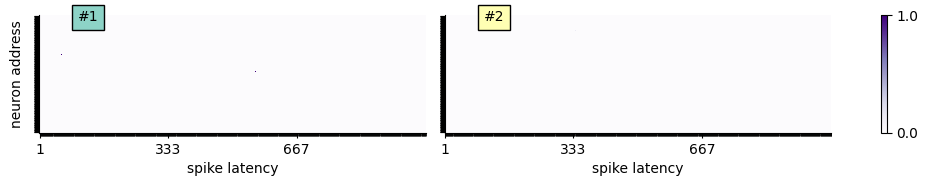

In [56]:
plot_SM(sm.SMs);

In [57]:
sm.SMs.unique()

tensor([0.0000e+00, 2.7554e-23, 1.9287e-22, 9.9900e-04, 1.4286e-01, 1.0000e+00])

The raster plot is produced with a sequence of apparition of the different motifs and random activity when no motif occurs. 

In [58]:
number_of_trials = 1
input_rp, output_rp = sm.draw_input(nb_trials=number_of_trials)

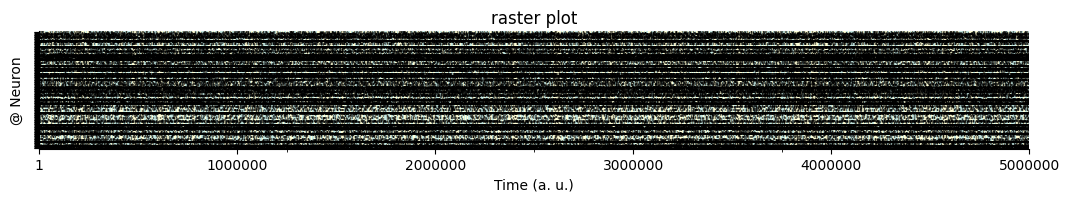

In [60]:
plot_colored_raster(input_rp, output_rp, dataset_parameters.N_delays, dataset_parameters.warping_coef);

The not structured spiking activity of the different neurons is given by their FRs (*parameters.frs*). Then, it is given by the occurence of a motif (colored parts of the raster plot) and the structure of the motif. The occurence of a motif is given by a random trial defining its timing and its type (or color).  

The raster plot is obtained with a Bernoulli trial on the probability distribution representing the non structured (flat distribution) or the structured (probability distributions of the different motifs). When motifs overlap the formula used to merge the motifs and obtain the expected raster plot is the following: 
$$Bernoulli(p) + Bernoulli(q) = Bernoulli(p+q-p*q)$$

It leads to Poisson distribution with an expected number of spike during the trial and their relative temporal dependencies that can vary with the number of motifs, their frequency of apparition (*parameters.freq_sm*) or the number of neurons involved in the motif (*parameters.N_involved*)

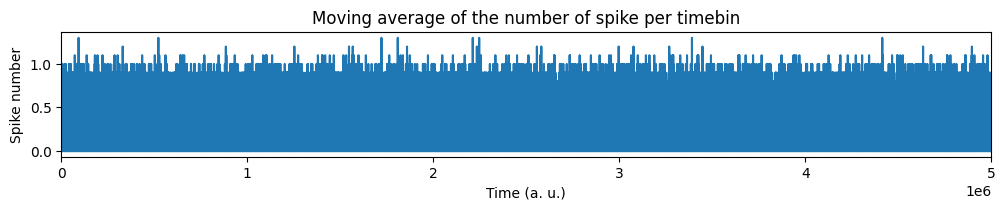

In [61]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
    
fig, ax = plt.subplots(figsize = (12, 1.61803))
ax.plot(moving_average(input_rp.sum(axis=(0,1)),10))
ax.set_xlim(0, dataset_parameters.N_timesteps)
ax.set_xlabel('Time (a. u.)')
ax.set_ylabel('Spike number')
ax.set_title('Moving average of the number of spike per timebin');

The instantaneous firing rate sumed over the different trials shows that the distribution is Poisson. And we can check the effective number of spikes per neuron compared to the expected firing rate. Firing rate of the different neurons can be easily changed, default is chosen by following a normal distribution around an average firing rate.  

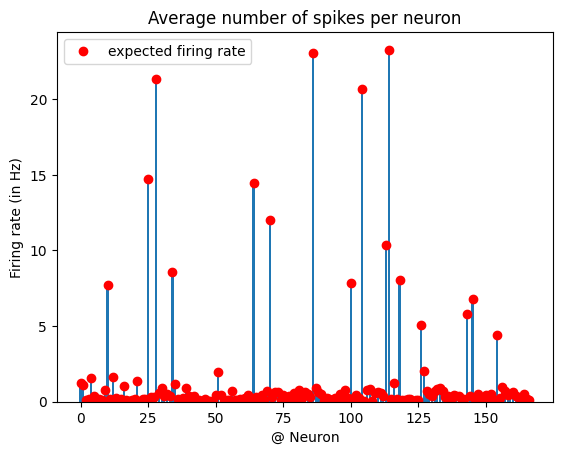

In [62]:
fig, ax = plt.subplots()
ax.bar(np.arange(dataset_parameters.N_pre),1e3*input_rp.mean(axis=(0,2)))
ax.plot(dataset_parameters.frs, 'ro', label='expected firing rate')
ax.set_xlabel('@ Neuron')
ax.set_ylabel('Firing rate (in Hz)')
ax.legend();
ax.set_title('Average number of spikes per neuron');

We can also check the number of occurence of the motifs and compare it to the expected number of occurence.

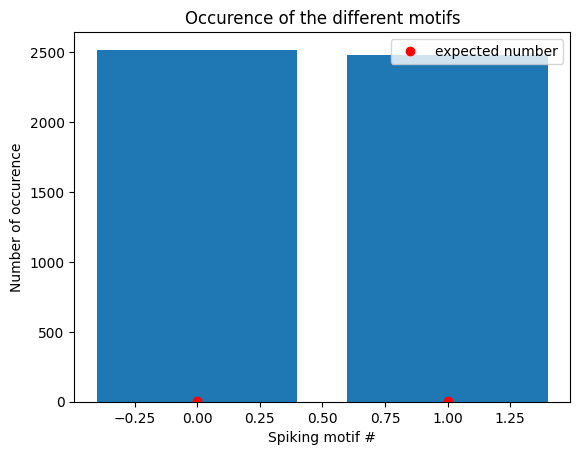

In [63]:
fig, ax = plt.subplots()
ax.bar(np.arange(dataset_parameters.N_SMs),output_rp.sum(axis=(0,2)))
ax.plot(dataset_parameters.freq_sms*number_of_trials, 'ro', label='expected number')
ax.set_xlabel('Spiking motif #')
ax.set_ylabel('Number of occurence')
ax.set_title('Occurence of the different motifs');
ax.legend();

In [64]:
isi = []
for sample in range(input_rp.shape[0]):
    for neurons in range(input_rp.shape[1]):
        spikes = torch.where(input_rp[sample,neurons]==1)[0]
        isi.append(spikes.diff())

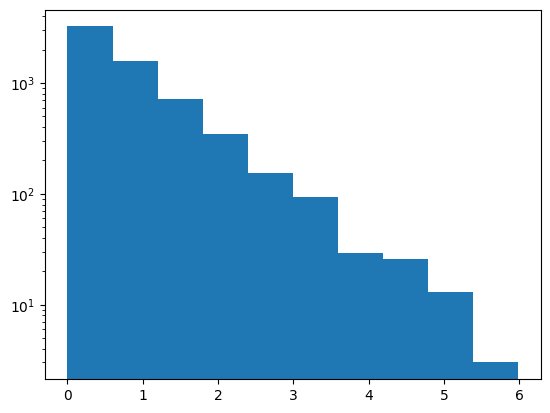

In [65]:
plt.hist(isi[0]*1e-3)
plt.yscale('log')

### 